In [1]:
#!pip install yfinance
#!pip install hmmlearn
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
import yfinance as yf
import pandas as pd
import numpy as np
from numpy import random
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from statsmodels.tsa.ar_model import AutoReg
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt

In [2]:
#compare 5 to 6 hidden states - performance

# Data collection

In [125]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


In [127]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

# Descriptive statistics

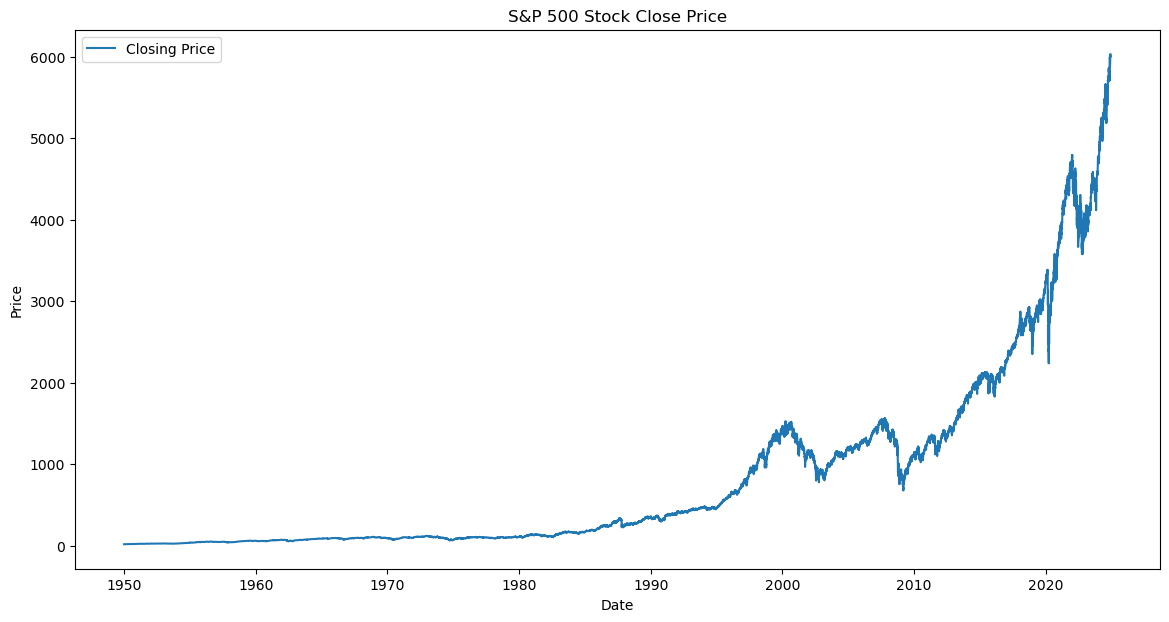

In [130]:
plt.figure(figsize=(14, 7))
plt.plot(daily.index, daily['Close'], label='Closing Price')
plt.title('S&P 500 Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig("Close_all.png", format='png', dpi=300)  
plt.show()

In [150]:
clean_daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
clean_daily.loc[(clean_daily['Open'] == 0), 'Open'] = np.nan
clean = clean_daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
clean = clean.dropna()

descriptive_stats = {
    "Price": ["Open", "High", "Low", "Close"],
    "Min": [clean['Open'].min(), clean['High'].min(), clean['Low'].min(), clean['Close'].min()],
    "Max": [clean['Open'].max(), clean['High'].max(), clean['Low'].max(), clean['Close'].max()],
    "Mean": [clean['Open'].mean(), clean['High'].mean(), clean['Low'].mean(), clean['Close'].mean()],
    "Std.": [clean['Open'].std(), clean['High'].std(), clean['Low'].std(), clean['Close'].std()],
}

summary_table = pd.DataFrame(descriptive_stats)
summary_table = summary_table.round(2)
summary_table.to_csv('summary_table.csv', index=False, sep=';')

latex_table = summary_table.to_latex(index=False, float_format="%.2f")

# Save to a .tex file
with open("table.tex", "w") as file:
    file.write(latex_table)

summary_table

[*********************100%%**********************]  1 of 1 completed


,Price,Min,Max,Mean,Std.
0,Open,16.66,5757.73,1098.44,1235.74
1,High,17.09,6044.17,1136.18,1279.12
2,Low,16.66,5696.51,1061.21,1195.06
3,Close,17.05,6032.38,1106.73,1248.43


# Model Selection

In [10]:
#Method 1 : visual choice (small edit)
sample = monthly[561:801] #1996-12-01 to 2016-01-01
sample = sample[sample.columns[1:5]]
monthly = monthly[monthly.columns[1:5]]

# Set the number of observations to consider for each iteration
T = 120

AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    np.random.seed(42)
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = GaussianHMM(n_components=n, n_iter=T)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = GaussianHMM(n_components=n, init_params="c", n_iter=T)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(sample[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(sample[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

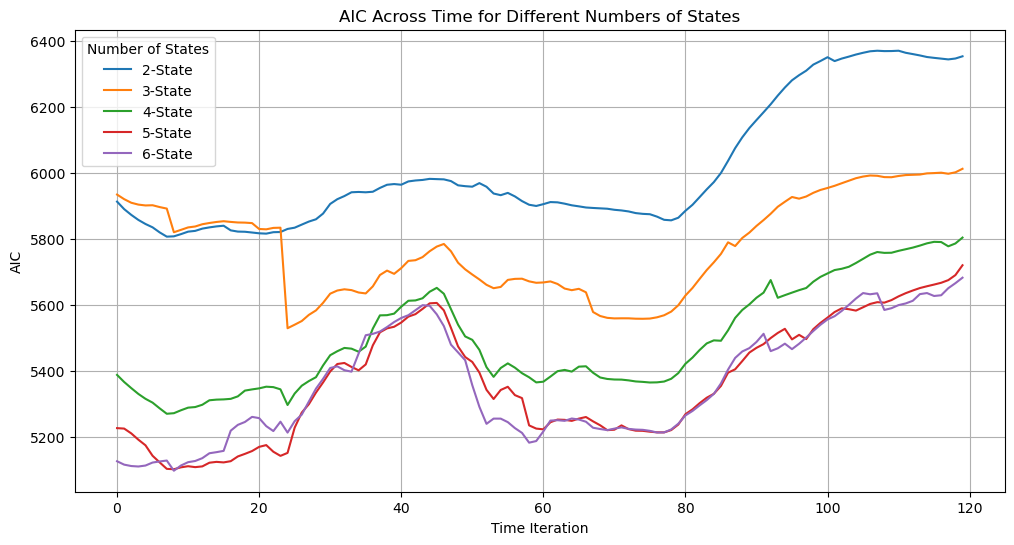

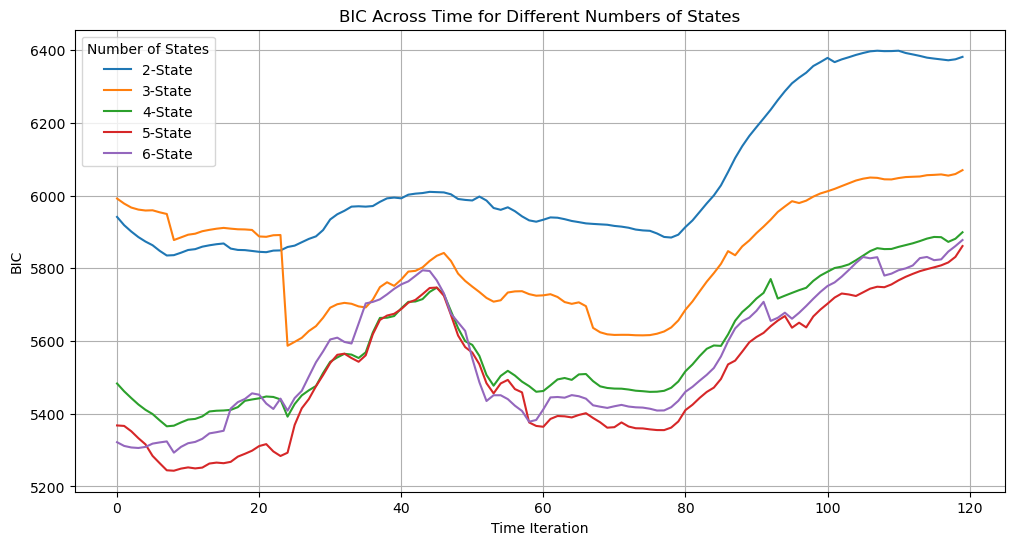

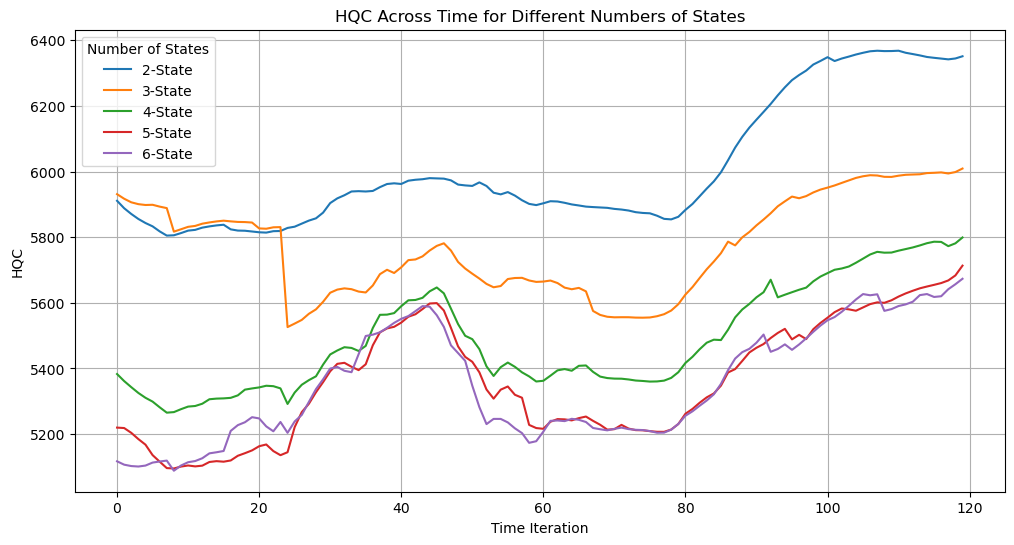

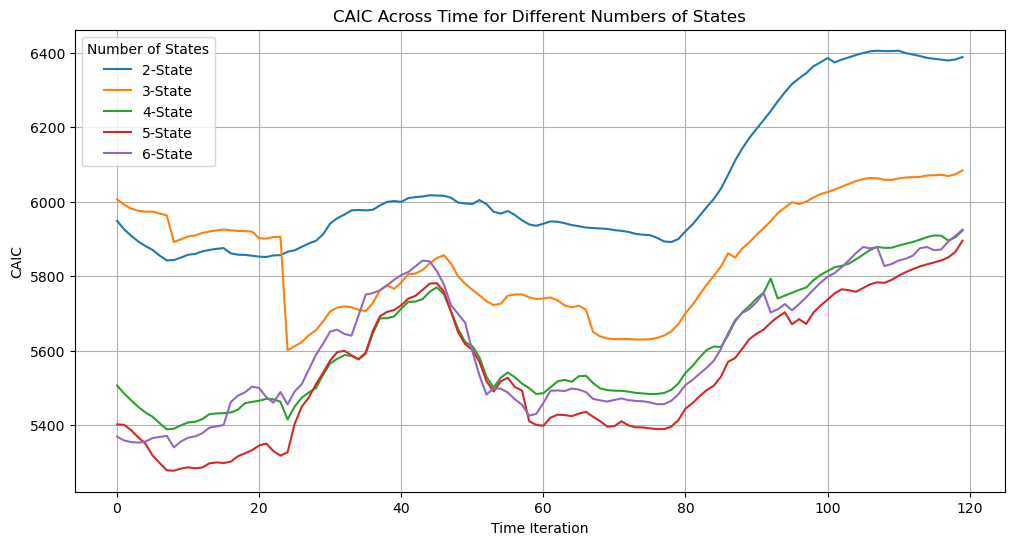

In [11]:
#Plot AIC values for different numbers of components
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.title("AIC Across Time for Different Numbers of States")
plt.ylabel("AIC")
plt.xlabel("Time Iteration")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("AIC_plot.png", format='png', dpi=300)  # Save as PNG
plt.show()

#Plot BIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.title("BIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("BIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("BIC_plot.png", format='png', dpi=300)  
plt.show()

#Plot HQC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.title("HQC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("HQC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("HQC_plot.png", format='png', dpi=300) 
plt.show()

#Plot CAIC 
plt.figure(figsize=(12, 6))
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.title("CAIC Across Time for Different Numbers of States")
plt.xlabel("Time Iteration")
plt.ylabel("CAIC")
plt.grid(True)
plt.legend(title="Number of States")
plt.savefig("CAIC_plot.png", format='png', dpi=300)  
plt.show()

In [12]:
#Method 2 : algoritmic choice 
#we are using the same obs as before
state_range = range(2, 7) 
best_model = None
best_criteria = {"AIC": float('inf'), "BIC": float('inf'), "HQC": float('inf'), "CAIC": float('inf')}
data_length = len(sample)
T=120

def calculate_model_criteria(hmm_model, M, k):                  #M as number of observations, k as number of parameters 
    L = hmm_model.score(sample)                                    #Use the correct model passed as the argument
    aic = -2 * L + 2 * k
    bic = -2 * L + k * np.log(M)
    hqc = -2 * L + 2 * k * np.log(np.log(M))
    caic = -2 * L + k * (1 + np.log(M))
    return {"AIC": aic, "BIC": bic, "HQC": hqc, "CAIC": caic}
 
for num_states in state_range:
    model = GaussianHMM(n_components=num_states, covariance_type='diag', random_state=42)
    model.fit(sample)

    # Number of parameters: Transition, emission, and initial probabilities
    num_params = num_states ** 2 + 2 * num_states - 1
    
    # Calculate evaluation criteria
    criteria = calculate_model_criteria(model, data_length, num_params)
    
    # Update best model based on BIC as the primary criterion
    if criteria["BIC"] < best_criteria["BIC"]:
        best_model = model
        best_criteria = criteria

print("Best Model Criteria:", best_criteria)
print(num_params)
print(num_states)

Best Model Criteria: {'AIC': 11321.09128916375, 'BIC': 11484.681318560824, 'HQC': 11387.0061276491, 'CAIC': 11531.681318560824}
47
6


# Prediction using HMM

In [14]:
# Calculate number of rows and set training window
T = 779  # Set the starting point for training data (from row 1 to row 779 leaving 120 oos obs)

# Define the size of the training window
d = 120
D = 120
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = monthly.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(42)

    if(first_time):
        first_time = False
        model = hmm.GaussianHMM(n_components=6) # 5 or 6
    else:
        old_model = model
        model = hmm.GaussianHMM(n_components=6, init_params="c") # here too
        model.startprob_ = old_model.startprob_
        model.transmat_ = old_model.transmat_
        model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t = T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t - D > 0:
        t = t - 1

        train_data = monthly.iloc[t - D:t]
        new_likelihood = model.score(train_data)
        if abs(new_likelihood - original_likelihood) < min_diff:  # Threshold for comparison
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = monthly['Close'][T - 1] + ((monthly['Close'][min_t + 1] - monthly['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T = T + 1

# Plot the predicted and observed prices from rows 682 to 802
close = []
truncated_obs = monthly.iloc[779:]

for i in truncated_obs['Close']:
    close.append(i)

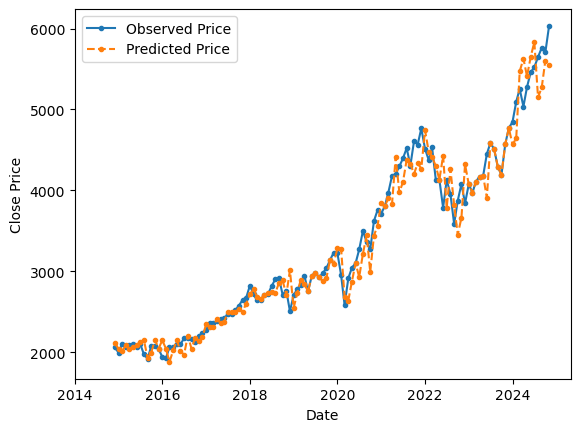

In [15]:
#Plotting hmm predictions
dates = monthly_with_dates.index[779:]

# Plot the data
plt.plot(dates, close, marker='.', label="Observed Price")
plt.plot(dates, hmm_price, marker='.', label="Predicted Price", linestyle='--')

plt.xlabel("Date")
plt.ylabel("Close Price")


years = dates.year.unique()
ticks = [year for year in years if year % 2 == 0]  # Show ticks every 5 years

# Set x-ticks to those years
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in ticks]))
plt.gca().set_xticklabels([f"{year}" for year in ticks])

# Add the legend and display the plot
plt.legend()
plt.savefig("HMM_pred.png", format='png', dpi=300)  
plt.show()

# Predictions using HAR

In [17]:
T = 779  # Starting point for predictions
d = 120  
D = 120 
har_price = []

# Calculate HAR-predicted prices
for t in range(T, T + d):
    # Historical returns for the past D days
    historical_returns = monthly['Close'].pct_change().iloc[t-D:t].dropna()
    
    avg_return = historical_returns.mean()
    
    # Use the previous day's price to calculate the predicted price
    predicted_price = monthly['Close'].iloc[t-1] * (1 + avg_return)
    har_price.append(predicted_price)

# Performance Evaluation

In [19]:
hmm_price = pd.DataFrame(hmm_price)
hmm_price = hmm_price.round(2)
hmm_price.to_csv('predicted_price.csv', index=False, sep=';')

In [20]:
observed_price = pd.DataFrame(close)
observed_price = observed_price.round(2)
observed_price.to_csv('observed_price.csv', index=False, sep=';')

In [21]:
#RMSE for HMM
RMSE_hmm = root_mean_squared_error(hmm_price, observed_price)

In [22]:
#R^2 for HMM
r2_hmm = r2_score(hmm_price, observed_price)

In [23]:
har_price = pd.DataFrame(har_price)
har_price = har_price.round(2)
har_price.to_csv('predicted_har_price.csv', index=False, sep=';')

In [24]:
RMSE_har = root_mean_squared_error(har_price, observed_price)

In [25]:
r2_har = r2_score(har_price, observed_price)

In [26]:
# Create a table to display the results
performance = {
    "Model": ["HAR", "HMM"],
    "$R^2$": [r2_har, r2_hmm],
    "RMSE": [RMSE_har, RMSE_hmm],
}

performance_table = pd.DataFrame(performance)

latex_table2 = performance_table.to_latex(index=False, float_format="%.2f")

# Save to a .tex file
with open("performance.tex", "w") as file:
    file.write(latex_table2)

performance_table

,Model,$R^2$,RMSE
0,HAR,0.978672,155.173386
1,HMM,0.959573,211.551060


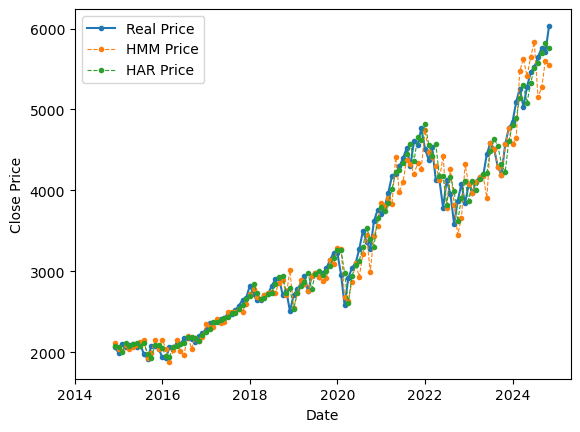

In [27]:
dates2 = monthly_with_dates.index[779:]

plt.plot(dates2, observed_price,marker='.', label = "Real Price")
plt.plot(dates2, hmm_price,marker='.', label = "HMM Price", linestyle='--', linewidth=0.8)
plt.plot(dates2, har_price,marker = '.', label= "HAR Price", linestyle='--', linewidth=0.8)
plt.xlabel("Date")
plt.ylabel("Close Price")

years = dates2.year.unique()
ticks = [year for year in years if year % 2 == 0] 

# Set x-ticks to those years
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in ticks]))
plt.gca().set_xticklabels([f"{year}" for year in ticks])
plt.legend()
plt.savefig("Real_HAR_HMM_pred.png", format='png', dpi=300)  
plt.show()

HMM VS HAR

# Stock trading strategy 

## ver1

In [117]:
sp500_return = monthly_with_dates.reset_index()
sp500_return["Return"] = sp500_return["Close"].pct_change()  # Monthly returns
sp500_return = sp500_return.dropna()

# Step 2: Define the Trading Simulation Function
def trading_simulation(predicted_returns, close_prices, initial_investment=100, trading_cost=7):
    cash = 0
    shares = 0
    costs = 0
    last_traded_price = close_prices.iloc[0]  # Initialize with the starting price

    # Track the total cost of trading and changes in share price dynamically
    for ret, share_price in zip(predicted_returns, close_prices):
        if ret > 0 and shares == 0:  # Buy if positive prediction and not already holding shares
            shares = initial_investment
            cash -= share_price * initial_investment
            costs += trading_cost
            last_traded_price = share_price  # Update to the price at which we bought
        elif ret < 0 and shares > 0:  # Sell if negative prediction and holding shares
            cash += share_price * shares
            costs += trading_cost
            shares = 0
            last_traded_price = share_price  # Update to the price at which we sold

    # Calculate the final value of the portfolio
    final_value = cash + (shares * close_prices.iloc[-1])  # Remaining value includes unsold shares
    profit_percent = ((final_value - costs) / (initial_investment * last_traded_price)) * 100  # Profit percent based on initial investment

    return {
        "Investment": initial_investment * close_prices.iloc[0],
        "Earnings": final_value,
        "Cost": costs,
        "Profit (%)": profit_percent
    }


# Step 3: Train and Apply HMM
def apply_hmm(returns, n_states=6):
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=120, random_state=42)
    hmm.fit(returns.reshape(-1, 1))
    hidden_states = hmm.predict(returns.reshape(-1, 1))
    return hidden_states

# Step 4: Train and Apply HAR
def apply_har(returns, lags=3):
    model = AutoReg(returns, lags=lags).fit()
    predictions = model.predict(start=lags, end=len(returns) - 1)

    # Map predictions to buy/sell signals
    signals = np.zeros_like(returns)
    signals[lags:] = np.where(predictions > 0, 1, -1)  # Positive predictions -> buy, negative -> sell
    return signals
    
# Step 5: Buy & Hold Strategy
def buy_and_hold_strategy(returns):
    return np.ones_like(returns)  # Always positive (buy)

# Step 6: Simulate for Different Time Periods
time_periods = [
    {"start": "2021-07", "end": "2024-11", "months": 40},
    {"start": "2019-12", "end": "2024-11", "months": 60},
    {"start": "2018-04", "end": "2024-11", "months": 80},
    {"start": "2015-08", "end": "2024-11", "months": 100},
    {"start": "2014-11", "end": "2024-11", "months": 120}
]

results = []

for period in time_periods:
    # Filter data for the time period
    period_data = sp500_return[(sp500_return["Date"] >= period["start"]) & (sp500_return["Date"] <= period["end"])]
    returns = period_data["Return"].values
    close_prices = period_data["Close"]

    # Apply models
    hmm_states = apply_hmm(returns)
    har_predictions = apply_har(returns)
    buy_hold_predictions = buy_and_hold_strategy(returns)

    # Simulate trading
    hmm_result = trading_simulation(hmm_states, close_prices)
    har_result = trading_simulation(har_predictions, close_prices)
    buy_hold_result = trading_simulation(buy_hold_predictions, close_prices)

    results.append({
        "Period": period["months"],
        "HMM": hmm_result,
        "HAR": har_result,
        "Buy & Hold": buy_hold_result,
    })

# Step 7: Display Results

# Initialize an empty list to hold the rows for the final table
formatted_results = []

# Loop through the results and format them
for result in results:
    period = result['Period']
    hmm_result = result['HMM']
    har_result = result['HAR']
    buy_hold_result = result['Buy & Hold']
    
    # Append HMM result
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "HMM",
        "Investment ($)": hmm_result["Investment"],
        "Earnings ($)": hmm_result["Earnings"],
        "Cost ($)": hmm_result["Cost"],
        "Profit (%)": hmm_result["Profit (%)"]
    })
    
    # Append HAR result
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "HAR",
        "Investment ($)": har_result["Investment"],
        "Earnings ($)": har_result["Earnings"],
        "Cost ($)": har_result["Cost"],
        "Profit (%)": har_result["Profit (%)"]
    })
    
    # Append Buy & Hold result
    formatted_results.append({
        "Trading Period": f"{period} months",
        "Model": "Buy & Hold",
        "Investment ($)": buy_hold_result["Investment"],
        "Earnings ($)": buy_hold_result["Earnings"],
        "Cost ($)": buy_hold_result["Cost"],
        "Profit (%)": buy_hold_result["Profit (%)"]
    })

# Convert the list of results into a DataFrame
formatted_df = pd.DataFrame(formatted_results)
formatted_df['Profit (%)'] = formatted_df['Profit (%)'].round(2)
formatted_df['Investment ($)'] = formatted_df['Investment ($)'].astype(int).apply(lambda x: f"{x:,}")
formatted_df['Earnings ($)'] = formatted_df['Earnings ($)'].astype(int).apply(lambda x: f"{x:,}")

results_tex = formatted_df.to_latex(index=False, float_format="%.2f")
with open("trading1.tex", "w") as file:
    file.write(results_tex)
    
formatted_df

Fitting a model with 47 free scalar parameters with only 41 data points will result in a degenerate solution.


,Trading Period,Model,Investment ($),Earnings ($),Cost ($),Profit (%)
0,40 months,HMM,"439,525","163,712",7,37.25
1,40 months,HAR,"439,525","164,804",91,29.16
2,40 months,Buy & Hold,"439,525","163,712",7,37.25
3,60 months,HMM,"323,078","280,159",7,86.71
4,60 months,HAR,"323,078","278,536",77,54.64
5,60 months,Buy & Hold,"323,078","280,159",7,86.71
6,80 months,HMM,"264,805","338,432",7,127.80
7,80 months,HAR,"264,805","261,028",119,51.20
8,80 months,Buy & Hold,"264,805","338,432",7,127.80
9,100 months,HMM,"197,218","406,019",7,205.87


## ver2

## ver1.5